# Movement prediction based on shoe insert pressure sensors

In [1]:
import numpy as np
import pandas as pd
import os
import re
from io import StringIO
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

## Preparing Data
### Loading data for each subject to one text file

In [2]:
folder_name = 'data_summaries'
# make folder if it doesnt exist
try:
    os.mkdir(folder_name)
    print("Directory" , folder_name ,  "created ") 
except FileExistsError:
    print("Directory" , folder_name ,  "already exists")


#join text files from each foder
for folder in os.listdir('data'):
    with open(os.path.join(folder_name, 'summary_{}.txt'.format(str(folder))), "w") as outfile:
        for textfile in os.listdir(os.path.join('data', folder)):
            contents = open( os.path.join('data', folder, textfile) ).read()
            outfile.write(contents)

Directory data_summaries already exists


In [3]:
file_list = os.listdir('data_summaries')

In [4]:
def listToString(s):  
    str1 = '' 
    for ele in s:  
        str1 += ele
    return str1

### Loading all data into *df_val* and *df* as validation and train data

TYPE_ID:  
1. step forward  
2. stop  
3. walking  
4. walking up a ramp  
5. walking down a ramp  
6. walking up stairs  
7. walking down stairs  
8. standing on a right leg  
9. standing on left leg

In [5]:
data_rows = []
for text_file in file_list:
    subject_num = int(re.sub("[^0-9]", "", text_file))
    with open (os.path.join('data_summaries', text_file), 'r') as text_file:
        string = text_file.readlines()
        for line in tqdm(string):
            line_string = listToString( line[:-1] + '\t{}'.format(subject_num) + '\n')
            if len([s for s in line_string if '\t' in s]) == 14:
                data_rows.append(line_string)

columns = ['C_{}'.format(x) for x in range(12)] + ['TYPE_ID', 'MEASUREMENT_NO', 'SUB_NO']
print('Making string...')
data_string = ''.join(data_rows)
print('Making string object...')
string_object = StringIO(data_string)
print('Making data frame...')
df = pd.read_csv(string_object, sep='\t', header=None, usecols=range(15))
df.columns = columns
where_numeric = df.applymap(np.isreal).all(1)
df = df[where_numeric]
df['TYPE_ID'] = df['TYPE_ID']-1

100%|██████████| 210494/210494 [00:02<00:00, 98621.17it/s]
Making string...
Making string object...
Making data frame...


### normalizing data from 1 to 0

In [6]:
dataf = ((df-df.min())/(df.max()-df.min()))
dataf[['TYPE_ID', 'MEASUREMENT_NO', 'SUB_NO']] = df[['TYPE_ID', 'MEASUREMENT_NO', 'SUB_NO']]

## Exploration
### Pairplot of sample of 1000 for every typeID (disabled for performance reasons)



In [7]:
# from IPython.display import Image
# try:
#     os.mkdir('plots')
#     print("Directory" , 'plots' ,  "created ") 
# except FileExistsError:
#     print("Directory" , 'plots' ,  "already exists")

# for ID_type in dataf['TYPE_ID'].unique():
#     sns_plot = sns.pairplot(dataf[dataf['TYPE_ID']==ID_type].iloc[:, :12].sample(1000))
#     sns_plot.savefig("plots\\pairplot_{}.png".format(ID_type))

### Sensor $C_n$ and $C_{n+6}$ are very linearly corelated no matter the movement, they could be in the similar location

<AxesSubplot:xlabel='C_2', ylabel='C_8'>

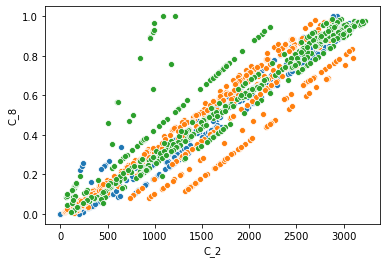

In [8]:
sample_size = 500
sns.scatterplot(df['C_0'], df['C_6'].sample(sample_size))
sns.scatterplot(df['C_1'], df['C_7'].sample(sample_size))
sns.scatterplot(df['C_2'], df['C_8'].sample(sample_size))

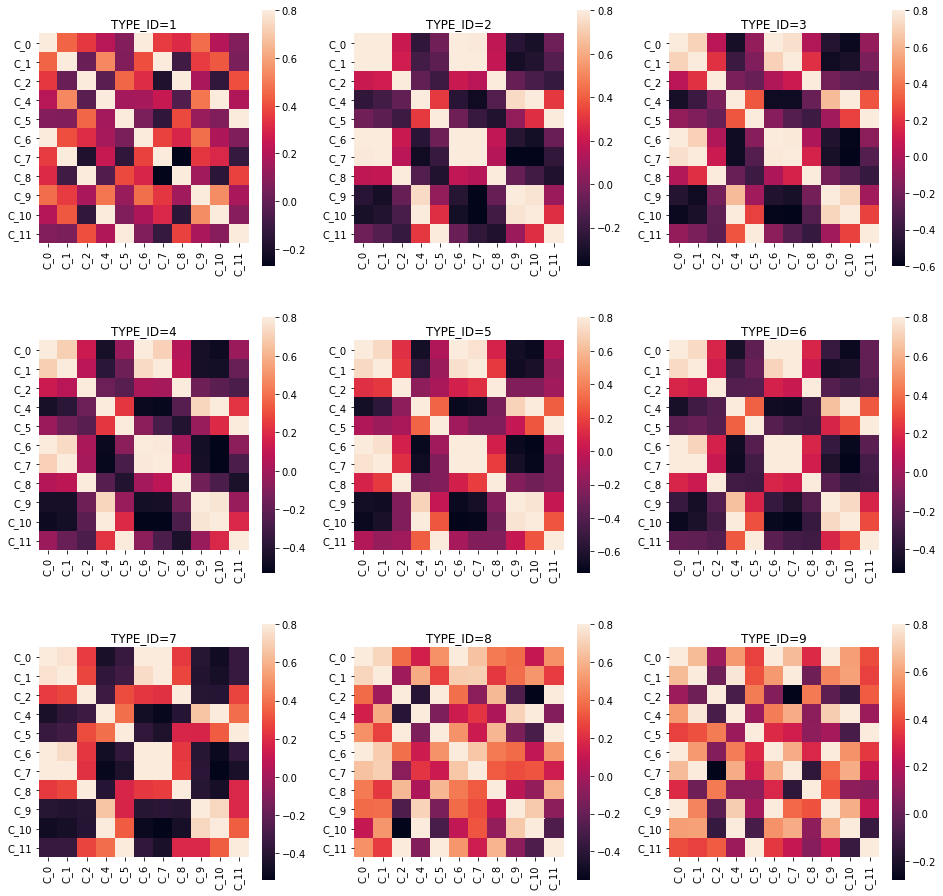

In [9]:
fig, ax = plt.subplots(figsize=(16, 16), ncols=3, nrows=3)
type_id = 0
for row in range(3):
    for col in range(3):
        corrmat = dataf[dataf['TYPE_ID']==type_id].iloc[:, :12].corr()
        sns.heatmap(corrmat, vmax=0.8, square=True, ax=ax[row, col]).set_title('TYPE_ID={}'.format(type_id+1));
        type_id += 1

movements with ID=8 or 9 have biggest correlation between columns, hense they are easiest to classify. The reason could be static nature of that movement(standing)

## Preparing data for network
### Nesting DataFrames

In [10]:
def make_nested(dataframe):
    train_data = pd.DataFrame()
    for sub in tqdm(dataframe['SUB_NO'].unique()):
        for measurement in dataframe['MEASUREMENT_NO'].unique():
            for type_id in dataframe['TYPE_ID'].unique():
                dfslice = dataframe[ (dataframe['SUB_NO']==int(sub)) & (dataframe['MEASUREMENT_NO']==int(measurement)) & (dataframe['TYPE_ID']==int(type_id))].iloc[:, :12]
                if dfslice.shape[0]!=0:
                    train_data = train_data.append(pd.DataFrame(
                        {'values': [dfslice],
                        'TYPE_ID': [type_id]}
                    ))
    return train_data
data = make_nested(dataf)
data.reset_index(drop=True, inplace=True)

100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


### Amount of every movement samples

In [11]:
data['TYPE_ID'].value_counts()

2    117
0    116
4    113
3    113
1    113
6    111
5    109
7     97
8     90
Name: TYPE_ID, dtype: int64

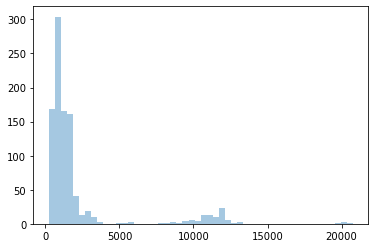

In [12]:
time_list = np.array([row.shape[0] for row in data.iloc[:, 0]])
sns.distplot(time_list, kde=False, norm_hist=False);

### fraction of data where dataframe with values are bigger than 512 (86%)
Data is being cut into windows of 512 windows which is unknown amount of time (due to unknown sampling rate)

In [13]:
#for dataframe with dataframe in column 0 and int value in column 1
import tensorflow as tf
def cut_to_windows(nested_df, window_size):    
    boolean_mask = [row.shape[0]>window_size for row in nested_df.iloc[:, 0]]
    time_list = np.array([row.shape[0] for row in nested_df.iloc[:, 0]])
    print('{:.4}% of data was cut off'.format((len(time_list[boolean_mask])/len(time_list))*100))

    list_of_trimmed_dataframes = []
    list_of_trimmed_IDs = []
    nested_df = nested_df[boolean_mask]    
    for dataframe, Id in zip(nested_df.iloc[:, 0], nested_df.iloc[:, 1]):
        timesteps = dataframe.shape[0]
        for step in range(timesteps//window_size):
            list_of_trimmed_IDs.append(Id)
            list_of_trimmed_dataframes.append(dataframe.iloc[step*window_size:(step+1)*window_size, :].to_numpy(dtype=np.float64))

    return (np.array(list_of_trimmed_dataframes), np.array(list_of_trimmed_IDs))

In [14]:
windows_size = 512
from skimage.measure import block_reduce
print("train data: ")
X, y = cut_to_windows(data, windows_size)


train data: 
84.68% of data was cut off


### Converting labels into categorical data

In [15]:
y = tf.keras.utils.to_categorical(y, num_classes=9)

### Creating Train, val and test data with 60/20/20 proportions

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=420)

## Neural Network

In [17]:
import tensorflow as tf
#this base model is one branch of the main model
#it takes a time series as an input, performs 1-D convolution, and returns it as an output ready for concatenation
def get_base_model(input_shape, f_dim):
    #the input is a time series of length n and width 19
    
    input_ = tf.keras.layers.Input(shape=(input_shape, 12))
    nb_filters = 32
    #1-D convolution and global max-pooling
    conv = tf.keras.layers.Conv1D(nb_filters, f_dim, padding="same", activation="tanh")(input_)
    processed = tf.keras.layers.GlobalMaxPooling1D()(conv)
    #dense layer with dropout regularization
    compressed = tf.keras.layers.Dense(1024, activation="tanh")(processed)
    compressed = tf.keras.layers.Dropout(0.3)(compressed)
    compressed = tf.keras.layers.Dense(512, activation="tanh")(processed)
    compressed = tf.keras.layers.Dropout(0.3)(compressed)
    compressed = tf.keras.layers.Dense(128, activation="tanh")(processed)
    compressed = tf.keras.layers.Dropout(0.3)(compressed)
    model = tf.keras.Model(inputs=input_, outputs=compressed)
    return model

In [18]:
get_base_model(512, 12).summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 12)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 512, 32)           4640      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
Total params: 8,864
Trainable params: 8,864
Non-trainable params: 0
_________________________________________________________________


In [19]:
#this is the main model
#it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an output
def main_model(inputs_lens = [128, 256, 512], fsizes = [8,16,24]):
    #the inputs to the branches are the original time series, and its down-sampled versions
    input_origseq = tf.keras.layers.Input(shape=(inputs_lens[2], 12))
    input_medseq = tf.keras.layers.MaxPool1D(pool_size=2)(input_origseq)
    input_smallseq = tf.keras.layers.MaxPool1D(pool_size=4)(input_origseq)
    #the more down-sampled the time series, the shorter the corresponding filter

    base_net_small = get_base_model(inputs_lens[0], fsizes[0])
    base_net_med = get_base_model(inputs_lens[1], fsizes[1])
    base_net_original = get_base_model(inputs_lens[2], fsizes[2])

    embedding_small = base_net_small(input_smallseq)
    embedding_med = base_net_med(input_medseq)
    embedding_original = base_net_original(input_origseq)
    #concatenate all the outputs
    merged = tf.keras.layers.Concatenate()([embedding_small, embedding_med, embedding_original])
    out = tf.keras.layers.Dense(9, activation='sigmoid')(merged)
    model = tf.keras.Model(inputs=input_origseq, outputs=out)
    return model
model = main_model()

In [20]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 12)]    0                                            
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 128, 12)      0           input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 256, 12)      0           input_2[0][0]                    
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 128)          7328        max_pooling1d_1[0][0]            
_______________________________________________________________________________________

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
import time
NAME = "model_{}".format(int(time.time()))

for folder_name in ['logs', 'saved_models', 'saved_models\\checkpoints']:
    try:
        os.mkdir(folder_name)
        print("Directory" , folder_name ,  "created ") 
    except FileExistsError:
        print("Directory" , folder_name ,  "already exists")

Directory logs created 
Directory saved_models already exists
Directory saved_models\checkpoints already exists


In [24]:
num_epochs = 100
results = model.fit(
    X_train, y_train,
    epochs = num_epochs,
    batch_size = 16,
    verbose = 1,
    validation_data = (X_val, y_val),
    callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='logs\\{}'.format(NAME)),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
        ]
    )

Epoch 1/100
  1/132 [..............................] - ETA: 0s - loss: 2.2009 - accuracy: 0.0000e+00WARNING:tensorflow:From C:\Users\skaya\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
132/132 [==============================] - 1s 7ms/step - loss: 1.2229 - accuracy: 0.6297 - val_loss: 0.9352 - val_accuracy: 0.6828
Epoch 2/100
132/132 [==============================] - 1s 5ms/step - loss: 0.8365 - accuracy: 0.7231 - val_loss: 0.6884 - val_accuracy: 0.7511
Epoch 3/100
132/132 [==============================] - 1s 5ms/step - loss: 0.6782 - accuracy: 0.7738 - val_loss: 0.6115 - val_accuracy: 0.8037
Epoch 4/100
132/132 [==============================] - 1s 5ms/step - loss: 0.5879 - accuracy: 0.8122 - val_loss: 0.4971 - val_accuracy: 0.8421
Epoch 5/100
132/132 [===================

In [25]:
model.evaluate(X_test, y_test)

22/22 [==============================] - 0s 2ms/step - loss: 0.1900 - accuracy: 0.9276


[0.18996013700962067, 0.9275568127632141]

## Model accuracy is around 92.7% for test data